In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Load Data

In [3]:
import pandas as pd

In [4]:
# train_Xy = pd.read_csv('exploratory_data_analysis/data_elasticsearch/train_Xy.csv')
# val_Xy = pd.read_csv('exploratory_data_analysis/data_elasticsearch//val_Xy.csv')
# test_Xy = pd.read_csv('exploratory_data_analysis/data_elasticsearch//test_Xy.csv')

In [5]:
train_Xy = pd.read_csv('exploratory_data_analysis/data_teammates/train_Xy.csv')
val_Xy = pd.read_csv('exploratory_data_analysis/data_teammates//val_Xy.csv')
test_Xy = pd.read_csv('exploratory_data_analysis/data_teammates//test_Xy.csv')

## Transform Input Data

In [6]:
def consolidate_data(df):
    return df.to_dict(orient='records')

train_data = consolidate_data(train_Xy)
val_data = consolidate_data(val_Xy)
test_data = consolidate_data(test_Xy)

### Tokenize

In [7]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/pu_xiao_berkeley_edu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
import json

body_max_length = 100
diff_max_length = 400

w2i = {}
with open('code_to_review/saved_data/code_to_review_w2i.json', 'r') as f:
    w2i = json.load(f)
i2w = {}
with open('code_to_review/saved_data/code_to_review_i2w.json', 'r') as f:
    i2w = json.load(f)

unkI_w, padI_w, startI_w = w2i['UNK'], w2i['PAD'], w2i['<START>']

In [9]:
# tokenize reviews
import numpy as np
from nltk import tokenize
import torch
from transformers import *
from nltk import word_tokenize

In [10]:
code_pretrained_weights = 'huggingface/CodeBERTa-small-v1'
code_tokenizer = AutoTokenizer.from_pretrained(code_pretrained_weights)

In [11]:
import re

def numerize_body(body):
    words = word_tokenize(body)
    return [w2i.get(w, unkI_w) for w in words]

def numerized_to_word(numerized):
    return " ".join([i2w.get(str(i)) for i in numerized])

def pad_sequence(numerized, max_length, padI):
    pad = numerized[:max_length]
    padded = pad + [padI] * (max_length - len(pad))
    return padded

def calculate_mask(padded, padI):
    return [c != padI for c in padded]

def preprocess(data):
    for record in data:
        clean_review = re.sub(r'`.+`', '', record['body'].replace("\n", " "))
        
        record['body_encoded'] = pad_sequence(numerize_body(clean_review), body_max_length, padI_w)
        record['body_mask'] = calculate_mask(record['body_encoded'], padI_w)
        
        dict_data = code_tokenizer.encode_plus(record['augmented_diff_hunk'], max_length=diff_max_length, pad_to_max_length=True)
        record['diff_hunk_encoded'] = np.array(dict_data['input_ids'])
        record['diff_hunk_mask'] = np.array(dict_data['attention_mask'])

In [12]:
preprocess(train_data)
preprocess(val_data)
preprocess(test_data)

In [13]:
numerized_to_word(val_data[0]['body_encoded'])

'I UNK if it will be better if we just returned < code > UNK < /code > , instead of making a new field ? PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD'

In [14]:
code_tokenizer.decode(val_data[0]['diff_hunk_encoded'][:50]), val_data[0]['diff_hunk_encoded'][:50]

('<s> --- InstructorFeedbackEditPageData.java\n+++ InstructorFeedbackEditPageData.java\n@@ -309,6 +309,15 @@ public void setStatusForAjax(String statusForAjax) {\n         this.statusFor',
 array([    0, 14627,   893,  3048, 14660,  4902,  1747,   682,    18,
         3937,   203,  1046,    15,   893,  3048, 14660,  4902,  1747,
          682,    18,  3937,   203, 26947,   561, 36120,    16,    26,
          424, 36120,    16,  2943, 24065,  1291,   954, 36877,  1370,
        13069,    12,   570,  2111,  1370, 13069,    13,   284,   203,
          264,   530,    18,  1430,  1370]))

### Build Batch

In [15]:
def build_batch(dataset, batch_size):
    indices = list(np.random.randint(0, len(dataset), size=min(batch_size, len(dataset))))
    
    batch = [dataset[i] for i in indices]
    
    y_encoded = np.array([element['body_encoded'] for element in batch])
    start_tokens = np.full((batch_size, 1), startI_w)
    y_input = np.concatenate((start_tokens, y_encoded), axis=1)
    y_input = y_input[:, :-1]
    
    y_target = y_encoded
    
    y_target_mask = np.array([a['body_mask'] for a in batch])
    
    X_encoded = np.array([element['diff_hunk_encoded'] for element in batch])
    X_mask = np.array([element['diff_hunk_mask'] for element in batch])

    return X_encoded, X_mask, y_input, y_target, y_target_mask

In [16]:
X_encoded, X_mask, y_input, y_target, y_target_mask = build_batch(train_data, 10)

print(X_encoded.shape)
print(X_mask.shape)
print(y_input.shape)
print(y_target.shape)
print(y_target_mask.shape)

(10, 400)
(10, 400)
(10, 100)
(10, 100)
(10, 100)


In [17]:
numerized_to_word(y_input[7])

'<START> @ UNK got it . PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD'

### Model

In [18]:
import torch
import torch.nn as nn

In [ ]:
from code_to_review.models.code_to_review_lstm import CodeToReviewModelLSTM

In [19]:
from code_to_review.models.code_to_review_transformer import CodeToReviewModelTransformer

### Visualization

In [20]:
from util.training_process_recorder import TrainingProcess

### Trainning

In [ ]:
code_to_review_model = CodeToReviewModelLSTM(startI_w=startI_w, 
                                             code_max_length=diff_max_length, 
                                             review_vocab_size=len(w2i),
                                             code_pretrained_weights=code_pretrained_weights, should_tune_encoder=False,
                                             word_embed_dim=256, hidden_dim=256, lstm_layers=1, output_attentions=False)
code_to_review_model = code_to_review_model.to(code_to_review_model.device)

In [ ]:
code_to_review_model = CodeToReviewModelLSTM(startI_w=startI_w, 
                                             code_max_length=diff_max_length, 
                                             review_vocab_size=len(w2i),
                                             code_pretrained_weights=code_pretrained_weights, should_tune_encoder=True,
                                             word_embed_dim=256, hidden_dim=256, lstm_layers=1, output_attentions=False)
code_to_review_model = code_to_review_model.to(code_to_review_model.device)

In [21]:
code_to_review_model = CodeToReviewModelTransformer(startI_w=startI_w, padI_w=padI_w, 
                                                    review_vocab_size=len(w2i), 
                                                    output_attentions=False,
                                                    encoder_pretrained_weights=code_pretrained_weights, should_tune_encoder=False,
                                                    decoder_hidden_size=384, decoder_num_layers=4, 
                                                    decoder_num_attention_heads=4, decoder_intermediate_size=256)
code_to_review_model = code_to_review_model.to(code_to_review_model.device)

In [ ]:
code_to_review_model = CodeToReviewModelTransformer(startI_w=startI_w, padI_w=padI_w, 
                                                    review_vocab_size=len(w2i), 
                                                    output_attentions=False,
                                                    encoder_pretrained_weights=code_pretrained_weights, should_tune_encoder=True,
                                                    decoder_hidden_size=384, decoder_num_layers=4, 
                                                    decoder_num_attention_heads=4, decoder_intermediate_size=256)
code_to_review_model = code_to_review_model.to(code_to_review_model.device)

In [22]:
tp = TrainingProcess()

In [ ]:
if torch.cuda.is_available():
    code_to_review_model.load_state_dict(torch.load('code_to_review/saved_data/code_to_review_lstm_code_bert.save'))
else:
    code_to_review_model.load_state_dict(torch.load('code_to_review/saved_data/code_to_review_lstm_code_bert.save', 
                                                    map_location=torch.device('cpu')))

code_to_review_model.eval();
tp.load("code_to_review/saved_data/code_to_review_lstm_code_bert_tp.save")

In [ ]:
if torch.cuda.is_available():
    code_to_review_model.load_state_dict(torch.load('code_to_review/saved_data/code_to_review_lstm_code_bert_tune.save'))
else:
    code_to_review_model.load_state_dict(torch.load('code_to_review/saved_data/code_to_review_lstm_code_bert_tune.save', 
                                                    map_location=torch.device('cpu')))

code_to_review_model.eval();
tp.load("code_to_review/saved_data/code_to_review_lstm_code_bert_tune_tp.save")

In [23]:
if torch.cuda.is_available():
    code_to_review_model.load_state_dict(torch.load('code_to_review/saved_data/code_to_review_transformer_code_bert.save'))
else:
    code_to_review_model.load_state_dict(torch.load('code_to_review/saved_data/code_to_review_transformer_code_bert.save', 
                                                    map_location=torch.device('cpu')))

code_to_review_model.eval();
tp.load("code_to_review/saved_data/code_to_review_transformer_code_bert_tune_tp.save")

In [ ]:
if torch.cuda.is_available():
    code_to_review_model.load_state_dict(torch.load('code_to_review/saved_data/code_to_review_transformer_code_bert_tune.save'))
else:
    code_to_review_model.load_state_dict(torch.load('code_to_review/saved_data/code_to_review_transformer_code_bert_tune.save', 
                                                    map_location=torch.device('cpu')))

code_to_review_model.eval();
tp.load("code_to_review/saved_data/code_to_review_transformer_code_bert_tune_tp.save")

In [ ]:
params = list(code_to_review_model.parameters())
optimizer = torch.optim.Adam(params, lr=0.0002, weight_decay=0.00012)
my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.995)

num_epochs = 25
batch_size = 64 # 64
log_step = 30

for epoch in range(num_epochs):
    num_train = len(train_data)
    iterations_per_epoch = max(num_train // batch_size, 1)
    
    for i in range(iterations_per_epoch):
        minibatch = build_batch(train_data, batch_size)
        X_encoded, X_mask, y_input, y_target, y_target_mask = minibatch
        code_to_review_model.train()
        code_to_review_model.zero_grad()
        loss = code_to_review_model(X_encoded, X_mask, y_input, y_target, y_target_mask)
        loss.backward()
        optimizer.step()
        
        tp.record_train(loss.item())
        tp.step()
        
        # Print log info
        if i % log_step == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i, iterations_per_epoch, loss.item()))

    val_minibatch = build_batch(val_data, batch_size)
    val_X_encoded, val_X_mask, val_y_input, val_y_target, val_y_target_mask = val_minibatch
    code_to_review_model.eval()
    code_to_review_model.zero_grad()
    val_loss = code_to_review_model(val_X_encoded, val_X_mask, val_y_input, val_y_target, val_y_target_mask)
    
    tp.record_val(val_loss.item())
    
    print('Epoch [{}/{}], Validation Loss: {:.4f}'.format(epoch + 1, num_epochs, val_loss.item()))
    
    tp.record_epoch()
    
    my_lr_scheduler.step()

In [ ]:
for i in range(len(test_data) // 20):
    test_minibatch = build_batch(test_data, 20)
    test_X_encoded, test_X_mask, test_y_input, test_y_target, test_y_target_mask = test_minibatch
    code_to_review_model.eval()
    code_to_review_model.zero_grad()
    test_loss = code_to_review_model(test_X_encoded, test_X_mask, test_y_input, test_y_target, test_y_target_mask)

    tp.record_test(test_loss.item())

    print('[Round {}] Test Loss: {:.4f}'.format(i + 1, test_loss.item()))

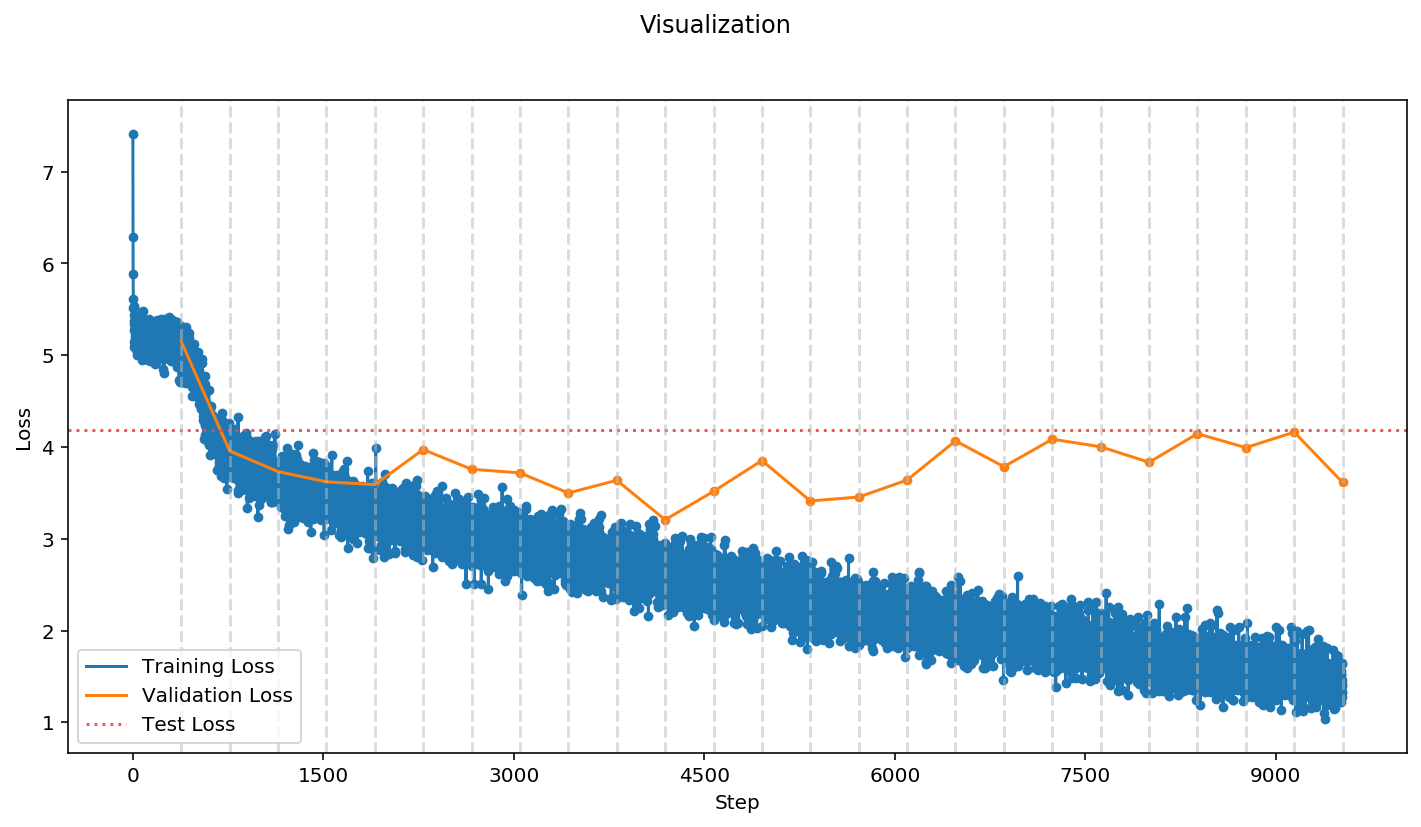

In [24]:
tp.visualize()

In [ ]:
torch.save(code_to_review_model.state_dict(), 'code_to_review/saved_data/code_to_review_lstm_code_bert.save')
tp.save('code_to_review/saved_data/code_to_review_lstm_code_bert_tp.save')

In [ ]:
torch.save(code_to_review_model.state_dict(), 'code_to_review/saved_data/code_to_review_lstm_code_bert_tune.save')
tp.save('code_to_review/saved_data/code_to_review_lstm_code_bert_tune_tp.save')

In [ ]:
torch.save(code_to_review_model.state_dict(), 'code_to_review/saved_data/code_to_review_transformer_code_bert.save')
tp.save('code_to_review/saved_data/code_to_review_transformer_code_bert_tp.save')

In [ ]:
torch.save(code_to_review_model.state_dict(), 'code_to_review/saved_data/code_to_review_transformer_code_bert_tune.save')
tp.save('code_to_review/saved_data/code_to_review_transformer_code_bert_tune_tp.save')

### Generation

In [25]:
minibatch = build_batch(train_data, 3)
code_encoded, code_mask, y_input, y_target, y_target_mask = minibatch

generated_texts = code_to_review_model.sample(code_encoded, code_mask, max_length=30, beam_size=4, topK=1)[0]

original_texts = y_target

for numerized, real_numberized in zip(generated_texts, original_texts):
    print("Generated:\n")
    for n in numerized:
        print(numerized_to_word(n))
        print('\n')

    print("Original:\n%s" % numerized_to_word(real_numberized))
    print('\n')

Generated:

<START> Could we remove this line : UNK : UNK : UNK # UNK ( ) { @ UNK } } } in the UNK UNK UNK UNK UNK UNK UNK


Original:
This is needed otherwise the line breaks will be UNK . UNK in one of the tests added . PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD


Generated:

<START> I do n't really understand this . If we need to replace `` with & UNK ; here , should n't the UNK for other characters in UNK be UNK


Original:
This is UNK how it 's done before . We can add more UNK if needed , no UNK . PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PA

In [26]:
minibatch = build_batch(test_data, 3)
code_encoded, code_mask, y_input, y_target, y_target_mask = minibatch

generated_texts = code_to_review_model.sample(code_encoded, code_mask, max_length=30, beam_size=4, topK=1)[0]

original_texts = y_target

for numerized, real_numberized in zip(generated_texts, original_texts):
    print("Generated:\n")
    for n in numerized:
        print(numerized_to_word(n))
        print('\n')

    print("Original:\n%s" % numerized_to_word(real_numberized))
    print('\n')

Generated:

<START> This should be fine on the previous line . It is UNK and UNK to UNK the line length limit UNK to UNK the UNK UNK UNK UNK UNK UNK


Original:
Maybe use the values from ) Likewise for the tests below . PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD


Generated:

<START> I do n't really understand this . If we need to replace `` with & UNK ; here , should n't the UNK for other characters in UNK be UNK


Original:
It is not ? PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD P